In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import xarray as xr
import sys
from glob import glob
# import scipy.signal

In [95]:
files = glob('/mnt/firex-s3/2019/*/*/akfiles/'+'*.nc')
test_file = "/mnt/firex-s3/2019/07/01/retfiles/NUCAPS-sciEDR_n20_pm_s201907012350550_e201907012358530.nc"

In [140]:
# Cycle through all files and extract the AK diagnonal, append to an array
# Note: in these AK files, there are 1800 FORs
dims = (len(files)*1800, 11)
diag_ch4 = np.full(dims, np.nan)
start_pos = 0

for ii, file in enumerate(files):
    df = xr.open_dataset(file)

    if ii == 0:
        cris_fors = df['atrack*xtrack'].values
        pch4 = df.ch4_func_pres.values
        pressure = df.Pressure

    # There are some funky AK values (e.g. beyond the 0 to 1 range...), but perform QC using if statement
    ak_ch4 = [np.diag(df.ch4_ave_kern.values[:-1,:-1, i]) for i in cris_fors if ((np.nansum(df.ch4_ave_kern.values[:-1,:-1,i]) > 0) & (df.qcmask.values[i] == 0))]

    for j in np.arange(0, len(ak_ch4)):
        diag_ch4[start_pos+j,:] = ak_ch4[j]

    start_pos = start_pos+j+1

In [1]:
df_nucaps = xr.open_dataset('NUCAPS-EDR_v2r0_npp_s20190430185959_e20190430190557_c20190430190557.nc')
pressure = df_nucaps.Pressure[0,:].values
effective_pressure = df_nucaps.Effective_Pressure[0,:].values

d = {'pressure': pressure, 'effective_pressure': effective_pressure}
df = pd.DataFrame(data=d)
df.to_csv('nucaps-pressure-grid.csv', index=False)

NameError: name 'xr' is not defined

In [137]:
# Calc mean/standard deviation
mean_ak = np.nanmean(diag_ch4, axis=0)
std_ak = np.nanstd(diag_ch4, axis=0)

In [162]:
fig, ax = plt.subplots(1,1, figsize=(3, 3))

ax.set_title("Methane Ave. Kern")

ax.errorbar(mean_ak, pch4, xerr=std_ak, c='tab:red', linewidth=1)
ax.set_ylim(1000,0)
ax.set_xlim(0,0.25)
plt.savefig('methane-ak.png')
plt.close()

In [155]:
d = {'press': pch4, 'mean': mean_ak, 'std': std_ak}

In [156]:
df = pd.DataFrame(data=d)

In [163]:
df.to_csv('firex-ch4-aks.csv', index=False)

In [3]:
trans_m = xr.open_dataset("NUCAPS_transformation_matrix.nc")

In [4]:
trans_m

<xarray.Dataset>
Dimensions:                 (air_temp_func_idx: 24, h2o_vap_func_idx: 12,
                             co_func_idx: 10, co2_func_idx: 9,
                             ch4_func_idx: 12, hno3_func_idx: 9,
                             o3_func_idx: 10, Number_of_P_Levels: 100)
Dimensions without coordinates: air_temp_func_idx, h2o_vap_func_idx,
                                co_func_idx, co2_func_idx, ch4_func_idx,
                                hno3_func_idx, o3_func_idx, Number_of_P_Levels
Data variables: (12/23)
    air_temp_func_pres      (air_temp_func_idx) float32 ...
    h2o_vap_func_pres       (h2o_vap_func_idx) float32 ...
    co_func_pres            (co_func_idx) float32 ...
    co2_func_pres           (co2_func_idx) float32 ...
    ch4_func_pres           (ch4_func_idx) float32 ...
    hno3_func_pres          (hno3_func_idx) float32 ...
    ...                      ...
    h2o_f_matrix            (Number_of_P_Levels, h2o_vap_func_idx) float32 ...
    co_f_matrix             (Number_of_P_Levels, co_func_idx) float32 ...
    co2_f_matrix            (Number_of_P_Levels, co2_func_idx) float32 ...
    ch4_f_matrix            (Number_of_P_Levels, ch4_func_idx) float32 ...
    hno3_f_matrix           (Number_of_P_Levels, hno3_func_idx) float32 ...
    o3_f_matrix             (Number_of_P_Levels, o3_func_idx) float32 ...
Attributes:
    title:        Transformation Matrix from Coarse to Fine Layers
    description:  The data in this file can be used to (i) convolve NUCAPS/CL...
    authors:      Nadia Smith (nadias@stcnet.com); Rebekah Esmaili (rebekah@s...
    institution:  Science and Technology Corp. (STC)
    references:   Smith et al., 2020. Community Long-term Infrared Microwave ...
    created:      Aug 23, 2021

In [10]:
# 100-lev AK Conversion example:
# https://github.com/resmaili/nucaps-f-matrix/blob/main/calc_nucaps_ak_allgases.pro
# Calc F*F+
# G_temp = (TRANSPOSE(finea)#finv)#TRANSPOSE(finea)
# AK100_T(iobs,*,*) = (G_temp#ak_tmp)#TRANSPOSE(G_temp)
fplus = trans_m.ch4_f_plus_matrix.values
fplus = np.ma.masked_invalid(fplus)
fplus = np.ma.masked_where(fplus >= 9.96e+36, fplus)

f = trans_m.ch4_f_matrix.values
f = np.ma.masked_invalid(f)
f = np.ma.masked_where(f >= 9.96e+36, f)

ffplus = np.ma.dot(f, fplus)

In [125]:
df = pd.read_csv('firex-ch4-aks.csv')
mean_ak = df['mean'].values
std_ak = df['std'].values
pch4 = df['press'].values

In [126]:
ch4_ave_kern = np.zeros((12,12))
vals = mean_ak
np.fill_diagonal(ch4_ave_kern, vals)

ch4_ave_kern_std = np.zeros((12,12))
vals = std_ak
np.fill_diagonal(ch4_ave_kern_std, vals)

In [128]:
# plt.figure()
# plt.imshow(ch4_ave_kern_std)
# plt.show()

In [129]:
# ak_t = ch4_ave_kern #12x12

g_t_T = trans_m.ch4_f_plus_matrix.values #12x100
g_t_T = np.ma.masked_invalid(g_t_T)

g_t = np.transpose(g_t_T) #100x12

lev100_ch4 = np.ma.dot(np.ma.dot(g_t, ch4_ave_kern), g_t_T)
lev100_ch4_std = np.ma.dot(np.ma.dot(g_t, ch4_ave_kern_std), g_t_T)

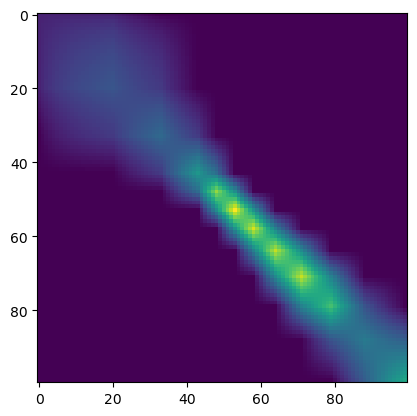

In [130]:
plt.figure()
plt.imshow(lev100_ch4_std)
plt.show()

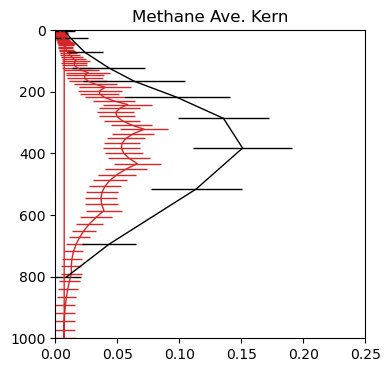

In [132]:
#AKs
fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.set_title("Methane Ave. Kern")
ax.errorbar(np.diag(lev100_ch4).filled(), effective_pressure, xerr=np.diag(lev100_ch4_std).filled(), c='tab:red', linewidth=1)
ax.errorbar(mean_ak, pch4, xerr=std_ak, c='k', linewidth=1)

ax.set_ylim(1000,0)
ax.set_xlim(0,0.25)
# plt.savefig('methane-ak.png')
# plt.close()
plt.show()


In [113]:
np.diag(lev100_ch4)

masked_array(data=[0.0019103248709671, 0.00196450476224514,
                   0.002085656332065365, 0.002239070033134074,
                   0.0024080544564486347, 0.002584343536278204,
                   0.002763077068826585, 0.00294145105188456,
                   0.003118026271802716, 0.003291727234559434,
                   0.0034621441787009216, 0.0036289240495948824,
                   0.0037919281940064766, 0.003951143689886753,
                   0.0041065937131421195, 0.004258366088601246,
                   0.004406511478704138, 0.004551173498997069,
                   0.004692451077604151, 0.004830462237802268,
                   0.0049653253155664, 0.004671847866835325,
                   0.004526160315019316, 0.004511011518139434,
                   0.0046114901579292255, 0.004814640564318694,
                   0.005109154313027945, 0.005485113446764991,
                   0.005933817942549146, 0.006447574082610591,
                   0.007019561239518231, 0.007643720943

In [111]:
np.diag(lev100_ch4).shape

(100,)

In [ ]:
fpres = trans_m.air_pres.values
feffpres = trans_m.air_pres_lay.values

In [6]:
ptmp = trans_m.air_temp_func_pres.values

NameError: name 'air_temp_ave_kern' is not defined